Fit the Hubble diagram for the Y1 TF galaxies to extract a value of $H_0$.

In [1]:
from astropy.table import Table
from astropy import cosmology
import astropy.units as u

import numdifftools as ndt

import numpy as np

import pickle

from tqdm import tqdm

from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [20]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Data

In [2]:
SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI.fits')
SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,132.22926444835167,2.692954944764243
55,SGA-2020 55,PGC1203947,1203947,199.7306

# TFR calibration (without dwarfs)

$V_0$, the slope, and the y-intercept are from `TF_Y1_cluster_calibration_KAD.ipynb`:

\begin{equation}
  M_r = a (\log(V(0.4R_{26})) - V_0) + b
\end{equation}

where
* $V_0 = 2.18$
* $a = -6.76^{+0.06}_{-0.07}$
* $b = -20.42 \pm 0.02$

*(Updated 8/14/24)*

In [3]:
temp_infile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs_KAD.pickle', 'rb')
cov_ab, tfr_samples, V0 = pickle.load(temp_infile)
temp_infile.close()

In [4]:
slope = np.median(tfr_samples[0])
slope_err = np.sqrt(cov_ab[0,0])

ZP = np.median(tfr_samples[1])
ZP_err = np.sqrt(cov_ab[1,1])

In [5]:
slopes = tfr_samples[0]
ZPs = tfr_samples[1]

# Compute expected absolute magnitude based on our calibrated TFR

In [6]:
SGA_TF['R_ABSMAG_SB26_TF'] = slope*(np.log10(SGA_TF['V_0p4R26']) - V0) + ZP

In [7]:
SGA_TF['R_ABSMAG_SB26_TF_err'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], SGA_TF['V_0p4R26_err'][i], size=len(slopes))
    
    Ms = slopes*(np.log10(v_random) - V0) + ZPs
    
    SGA_TF['R_ABSMAG_SB26_TF_err'][i] = np.nanstd(Ms)

  0%|          | 8/10264 [00:00<05:20, 32.05it/s]/tmp/ipykernel_1498664/3340772153.py:9: RuntimeWarning: invalid value encountered in log10
  Ms = slopes*(np.log10(v_random) - V0) + ZPs
100%|██████████| 10264/10264 [05:39<00:00, 30.26it/s]


# Compute distance moduli based on our calibrated TFR

In [8]:
SGA_TF['mu_TF'] = SGA_TF['R_MAG_SB26'] - SGA_TF['R_ABSMAG_SB26_TF']

SGA_TF['mu_TF_err'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_TF['R_ABSMAG_SB26_TF_err']**2)

# Hubble diagram

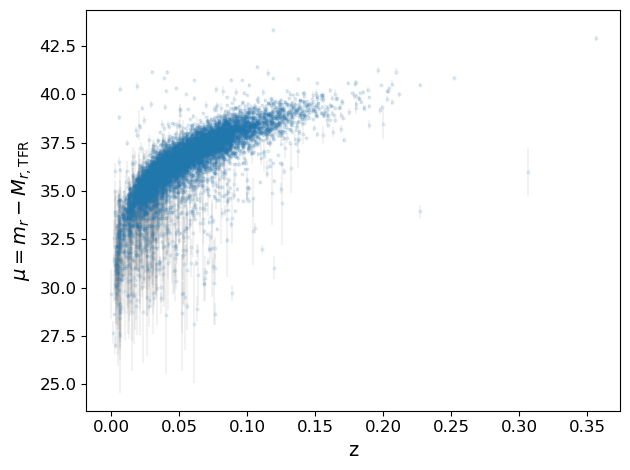

In [9]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF['Z_DESI'], 
             SGA_TF['mu_TF'], 
             xerr=SGA_TF['ZERR_DESI'], 
             yerr=SGA_TF['mu_TF_err'],
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\mu = m_r - M_{r, \text{TFR}}$', fontsize=14);

In [10]:
def cosmo_mu(H0, Om0, z):
    '''
    Calculate the distance modulus for a given H0 and Omega_M0.  Assumes a flat 
    Lambda CDM cosmology.
    
    PARAMETERS
    ==========
    H0 : ndarray of shape (1,)
        Hubble constant - parameter that is being fit for.  Must be in units of 
        km/s/Mpc.
    Om0 : float
        Omega_M0.  Must have a value between 0 and 1.
    z : float or ndarray of shape (n,)
        redshift at which to calculate distance modulus.
    
    RETURNS
    =======
    mu : float or ndarray of shape (n,)
        Distance modulus for the given H0 and Omega_M0.
    '''
    cosmo = cosmology.FlatLambdaCDM(H0=H0[0]*u.km/(u.s*u.Mpc), Om0=Om0)
    mu = cosmo.distmod(z)
    return mu.value

def logL_mu(H0, Om0, z, mu_data, mu_ivar):
    '''
    Log likelihood of the data and H0 for the distance modulus.
    
    PARAMETERS
    ==========
    H0 : float
        Hubble constant - parameter that is being fit for.  Must be in units of 
        km/s/Mpc.
    Om0 : float
        Omega_M0.  Must have a value between 0 and 1.
    z : float or ndarray of shape (n,)
        redshift at which to calculate distance modulus.
    mu_data : float or ndarray of shape (n,)
        Measured distance moduli
    mu_ivar : float or ndarray of shape (n,)
        Inverse variance in the measured distance moduli
        
    RETURNS
    =======
    logL : float
        Log likelihood of set distance moduli given H0
    '''
    lambda1 = cosmo_mu(H0, Om0, z)
    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny
    
    return -0.5*np.sum(mu_ivar*(mu_data - lambda1)**2 - np.log(mu_ivar))

def nlogL_mu(H0, Om0, z, mu_data, mu_ivar):
    '''
    Returns the negative log likelihood of the data and the value of H0.
    '''
    return -logL_mu(H0, Om0, z, mu_data, mu_ivar)


results = minimize(nlogL_mu, 
                   70, # initial guess for H0
                   args=(0.3, SGA_TF['Z_DESI'], SGA_TF['mu_TF'], 1/SGA_TF['mu_TF_err']**2), 
                   bounds=[[50, 100]])
results

      fun: 458166.51721160713
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01746231])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([73.5937501])

In [11]:
# H0_err = np.sqrt(np.diag(results.hess_inv.todense()))
hessian = ndt.Hessian(nlogL_mu)
hess = hessian(results.x, 0.3, SGA_TF['Z_DESI'], SGA_TF['mu_TF'], 1/SGA_TF['mu_TF_err']**2)
hess_inv = 2*np.linalg.inv(hess)
H0_err = np.sqrt(np.diag(np.abs(hess_inv)))
print(f'{results.x[0]:.2f} +/- {H0_err[0]:.2f}')

73.59 +/- 0.03


In [12]:
z = np.arange(0.001, 0.4, 0.001)
mu = cosmo_mu(results.x, 0.3, z)

N_samples = 10000
H0_rands = rng.normal(results.x[0], H0_err, size=N_samples)
mu_rands = np.zeros((N_samples, len(z)))
for i in range(N_samples):
    mu_rands[i] = cosmo_mu([H0_rands[i]], 0.3, z)

In [13]:
mu_stds = np.std(mu_rands, axis=0)

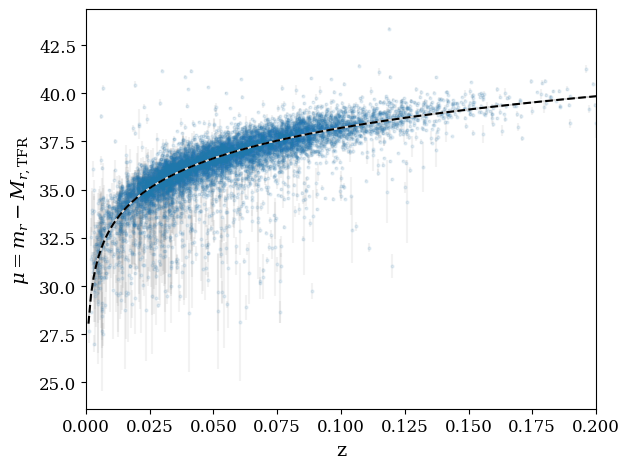

In [21]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF['Z_DESI'], 
             SGA_TF['mu_TF'], 
             xerr=SGA_TF['ZERR_DESI'], 
             yerr=SGA_TF['mu_TF_err'],
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray', 
             zorder=0)
plt.plot(z, mu, '--k', zorder=2)
plt.fill_between(z, mu - mu_stds, mu + mu_stds, color='lightgray', zorder=1)

plt.xlim((0,0.2))

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\mu = m_r - M_{r, \text{TFR}}$', fontsize=14);

# plt.savefig('../../Figures/Y1/Y1_TFR_Hubble.png', dpi=150, facecolor='none');